In [10]:
import sys
sys.path.append('../')
from lib.matrix_approach.layers import *
%load_ext autoreload
%autoreload 2

import flappy_bird_gymnasium
import gymnasium as gym
import numpy as np
import random
from IPython import display, embed
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array", pipe_gap=150)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32
n_episodes = 300000

In [12]:
class NN(Network):
    def __init__(self):
        self.layers = [
            FC(state_size, 64),
            ReLU(),
            FC(64, 128),
            ReLU(),
            FC(128, action_size),
        ]

    def __call__(self, inputs):
        input = np.array(inputs)
        return self.forward(input)

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size, model):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = (self.epsilon_min/self.epsilon) ** (1/n_episodes)

        self.learning_rate = 0.001
        self.model = model
        self.loss_fn = MSE()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, eval=False):
        if not eval and np.random.rand() <= self.epsilon:
            # return random.randrange(self.action_size)
            return random.choices([0, 1], weights=[75, 25])[0]
        act_values = self.model([state])
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([m[0] for m in minibatch])
        actions = np.array([m[1] for m in minibatch])
        rewards = np.array([m[2] for m in minibatch])
        next_states = np.array([m[3] for m in minibatch])
        dones = np.array([m[4] for m in minibatch])
        dones_idx = np.nonzero(dones)[0]

        outputs = self.model(next_states)
        targets = rewards + self.gamma * np.amax(outputs, axis=1)
        targets[dones_idx] = rewards[dones_idx]

        output = self.model(states)

        target_output = np.copy(output)
        for i, action in enumerate(actions):
            target_output[i][action] = targets[i]

        loss = self.loss_fn(output, target_output)
        self.model.backward(self.loss_fn)

        # Update weights
        params, grads = self.model.parameters()
        updated_params = params + -1 * self.learning_rate * grads
        self.model.set_parameters(updated_params)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

In [14]:
def eval(env, agent):
    env.reset()
    episode_lengths = []
    episode_rewards = []
    for e in range(10):
        state = env.reset()[0]
        done = False
        counter = 0
        total_reward = 0
        while not done:
            action = agent.act(state, eval=True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state
            counter += 1
            total_reward += reward
        episode_rewards.append(total_reward)
        episode_lengths.append(counter)
    return np.mean(episode_lengths), np.mean(episode_rewards)

In [15]:
def plot(data_1, data_2):
    display.clear_output(wait=True)

    plt.subplot(2, 1, 1)
    plt.plot(data_1)

    plt.subplot(2, 1, 2)
    plt.plot(data_2)

    display.display(plt.gcf())

KeyboardInterrupt: 

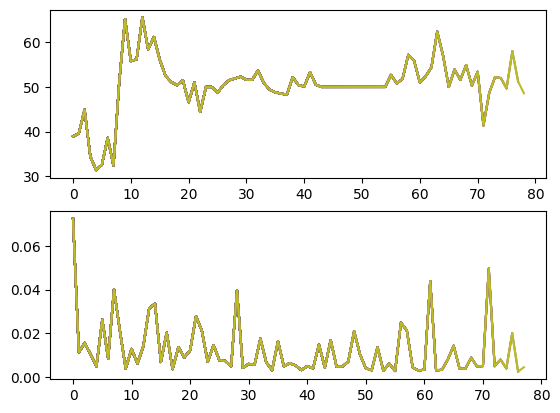

In [16]:
model = NN()
agent = DQNAgent(state_size, action_size, model)
done = False
eval_lens = []
eval_rewards = []
losses = []
eps_len = 0
for e in range(n_episodes):
    state = env.reset()[0]
    for time in range(5000):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            # print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon}")
            break
    if e % 1000 == 0:
        eps_len, eps_reward = eval(env, agent)
        eval_lens.append(eps_len)
        eval_rewards.append(eps_reward)
        if eps_len > 2000:
            break
    if len(agent.memory) > batch_size:
        loss = agent.replay(batch_size)
        if e % 1000 == 0:
            losses.append(loss)
            plot(eval_lens, losses[1:])
        print(f"episode: {e}/{n_episodes}, loss: {loss}, eval_length: {eps_len} e: {agent.epsilon}")

In [ ]:
agent.model.save('models/flappy_bird_gymnasium')

In [ ]:
# env.reset()
# img = plt.imshow(env.render())
# episode_lengths = []
# for e in range(5):
#     state = env.reset()[0]
#     done = False
#     counter = 0
#     while not done:
#         action = agent.act(state)
#         next_state, reward, terminated, truncated, info = env.step(action)
#         done = terminated or truncated
#         state = next_state
#         img.set_data(env.render()) # just update the data
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#         counter += 1
#     episode_lengths.append(counter)
# print(f"All episode lengths: {episode_lengths}")
# print(f"Average episode length: {np.mean(episode_lengths)}")
# env.close()